# 1-D finite rate chemistry for dissociating air -Arrhenius.jl

Add the necessary packages. Arrhenius.jl being the primary package (analogous to cantera, except more Julia-exploitable)

In [2]:
using Arrhenius
using LinearAlgebra
using DifferentialEquations
using ForwardDiff
using DiffEqSensitivity
using Sundials
using Plots
using DelimitedFiles
using Profile

In [3]:
gas = CreateSolution("../../mechanism/air.yaml")
ns = gas.n_species

8

In [4]:
gas.species_names

8-element Vector{String}:
 "O"
 "O2"
 "N"
 "NO"
 "NO2"
 "N2O"
 "N2"
 "AR"

In [5]:
Y0 = zeros(ns)
Y0[species_index(gas, "N2")] = 0.76
Y0[species_index(gas, "O2")] = 0.24
T0 = 5000.0
P = 2*one_atm
u0 = vcat(Y0, T0)

9-element Vector{Float64}:
    0.0
    0.24
    0.0
    0.0
    0.0
    0.0
    0.76
    0.0
 5000.0

In [6]:
#setup the function 
u0 = vcat(Y0, T0)
@inbounds function dudt!(du, u, p, t)
    T = u[end]
    Y = @view(u[1:ns])
    mean_MW = 1. / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end

dudt! (generic function with 1 method)

In [13]:
#solve the ODE problem
xspan = [0.0, 0.1];
prob = ODEProblem(dudt!, u0, xspan);
sol = solve(prob, TRBDF2(), reltol=1e-6, abstol=1e-9)

retcode: Success
Interpolation: 3rd order Hermite
t: 24-element Vector{Float64}:
 0.0
 1.218379815244834e-10
 1.3402177967693176e-9
 1.3524015949217658e-8
 1.3536199747370107e-7
 1.353741812718535e-6
 2.9878266427952084e-6
 6.993314414267698e-6
 1.1874173253899766e-5
 2.0220244973166054e-5
 3.268210316941358e-5
 5.1825971101687785e-5
 8.950033137610275e-5
 0.00014657329922861408
 0.00023508975755943945
 0.00035655254203915856
 0.0005468111555574203
 0.000835884441403384
 0.001504991209856333
 0.003293039526372675
 0.00703094625187624
 0.01750209101286037
 0.05430043364088979
 0.1
u: 24-element Vector{Vector{Float64}}:
 [0.0, 0.24, 0.0, 0.0, 0.0, 0.0, 0.76, 0.0, 5000.0]
 [4.182489997292097e-7, 0.2399995747521047, 5.239100937043766e-12, 1.125126515123817e-11, 1.4907692430780745e-17, 1.9237349331262364e-8, 0.7599999877450558, 0.0, 4999.994749908672]
 [4.599819582461636e-6, 0.23999532252880817, 6.264008018921218e-10, 1.3769547729425478e-9, 1.834850324873779e-14, 2.115986074021217e-7, 0.759

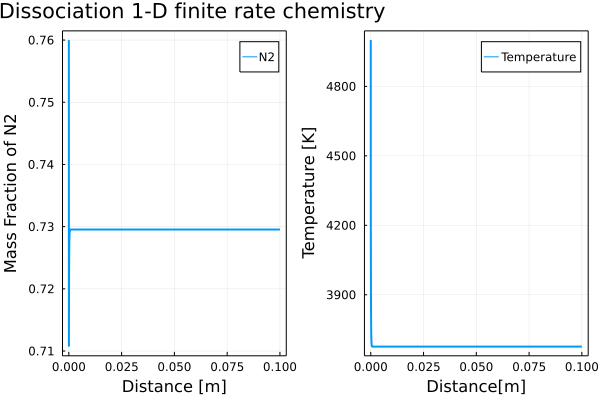

In [14]:
plt = plot(sol.t, sol[species_index(gas, "N2"), :], lw=2, label="N2");
ylabel!(plt, "Mass Fraction of N2")
xlabel!(plt, "Distance [m]")
pltT = plot(sol.t, sol[end, :], lw=2, label="Temperature");
ylabel!(pltT, "Temperature [K]")
xlabel!(pltT, "Distance[m]")
title!(plt, "Air Dissociation 1-D finite rate chemistry")
pltsum = plot(plt, pltT, legend=true, framestyle=:box)
# png(pltsum, "JP10_pyrolysis.png")

In [15]:
sol[species_index(gas,"N2"),:]
sol.t

24-element Vector{Float64}:
 0.0
 1.218379815244834e-10
 1.3402177967693176e-9
 1.3524015949217658e-8
 1.3536199747370107e-7
 1.353741812718535e-6
 2.9878266427952084e-6
 6.993314414267698e-6
 1.1874173253899766e-5
 2.0220244973166054e-5
 3.268210316941358e-5
 5.1825971101687785e-5
 8.950033137610275e-5
 0.00014657329922861408
 0.00023508975755943945
 0.00035655254203915856
 0.0005468111555574203
 0.000835884441403384
 0.001504991209856333
 0.003293039526372675
 0.00703094625187624
 0.01750209101286037
 0.05430043364088979
 0.1